In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D
from scipy.integrate import quad as quad
import sys
sys.path.insert(0, "/scratch/ierez/IGMCosmo/VoidFinder/python/")
#import voidfinder
#from voidfinder import distance
#from voidfinder.distance import z_to_comoving_dist
from astropy import constants as const
from astropy.table import Table

import os
from astropy.io import fits
in_directory='/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/'
os.chdir(in_directory)

In [2]:
data_directory = '/scratch/sbenzvi_lab/boss/dr16/delta_fields/'

deltas_filename = data_directory + 'deltafields_RAadded90.fits'

quasars_filename='/scratch/sbenzvi_lab/boss/dr16/delta_fields/quasars.fits'

In [3]:
deltas=fits.open(deltas_filename)  
deltas=Table(deltas[1].data)

quasars=fits.open(quasars_filename)  
quasars=Table(quasars[1].data)

In [4]:
quasars

ra,dec,z
float64,float64,float64
-34.90196644835447,-1.159330826846483,3.774
-34.692674572422334,-1.0531637172445856,3.446
-34.60865459248191,-0.8345530857219153,2.75148963928223
-34.472523569472685,-0.9748963978803513,2.704
-34.444164549902894,-1.142452301903663,2.341
-34.42495345854309,-0.7253719805422782,2.618
-34.38626621702588,-0.6943935181822574,2.116
-34.383540267834576,-0.7240672011037926,2.20196866989136
-34.35570880937678,-1.0621194224534276,2.226


In [5]:
c = const.c.to('km/s').value
#z to comoving
#voidfinder.distance.z_to_comoving_dist

Omega_M = 0.3147
c = const.c.to('km/s').value
def Distance(z,omega_m = Omega_M,h = 1):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

def f(a,omega_m = Omega_M):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))

quasars['z'].name='redshift'

quasars['r']= Distance(quasars['redshift'],Omega_M,1)

In [6]:
DtoR = np.pi/180.
ra_radian = quasars['ra']*DtoR
dec_radian = quasars['dec']*DtoR

quasars['x']= quasars['r']*np.cos(ra_radian)*np.cos(dec_radian)
quasars['y'] = quasars['r']*np.sin(ra_radian)*np.cos(dec_radian)
quasars['z'] = quasars['r']*np.sin(dec_radian)

In [7]:
quasars

ra,dec,redshift,r,x,y,z
float64,float64,float64,float64,float64,float64,float64
-34.90196644835447,-1.159330826846483,3.774,4832.81253150792,3962.734010508932,-2764.6437341335513,-97.78113300570077
-34.692674572422334,-1.0531637172445856,3.446,4657.527770830647,3828.850751592705,-2650.4977776276282,-85.6060095885592
-34.60865459248191,-0.8345530857219153,2.75148963928223,4215.34429893826,3469.07356303065,-2393.9270140575854,-61.39726572461205
-34.472523569472685,-0.9748963978803513,2.704,4180.800516204877,3446.1434819913425,-2366.03636481306,-71.13352381086978
-34.444164549902894,-1.142452301903663,2.341,3894.00482503552,3210.6608419559307,-2202.022395814789,-77.63957535202412
-34.42495345854309,-0.7253719805422782,2.618,4116.594594846443,3395.3724172745874,-2327.0327048301833,-52.115227914666114
-34.38626621702588,-0.6943935181822574,2.116,3692.996778095992,3047.417699994102,-2085.5376919924292,-44.75600595367359
-34.383540267834576,-0.7240672011037926,2.20196866989136,3772.142622767125,3112.8093137060578,-2130.0717930357187,-47.66864288887694
-34.35570880937678,-1.0621194224534276,2.226,3793.734586416724,3131.3794287971086,-2140.5466043830907,-70.32225497511864


## Estimate of minimum distance between data skewers

It would suffice to calculate the difference between x, y and z coordinates of all quasars and take the minimum.

In [8]:
diff_x=np.zeros(len(quasars['x'])*len(quasars['x'])+len(quasars['x']))
for i in range(len(quasars['x'])):
    for j in range(len(quasars['x'])):
        diff_x[i*len(quasars['x'])+j]= quasars['x'][i]-quasars['x'][j]

In [9]:
min(abs(diff_x))

0.0

In [10]:
diff_y=np.zeros(len(quasars['y'])*len(quasars['y'])+len(quasars['y']))
for i in range(len(quasars['y'])):
    for j in range(len(quasars['y'])):
        diff_y[i*len(quasars['y'])+j]= quasars['y'][i]-quasars['y'][j]

In [11]:
min(abs(diff_y))

0.0

In [12]:
diff_z=np.zeros(len(quasars['z'])*len(quasars['z'])+len(quasars['z']))
for i in range(len(quasars['z'])):
    for j in range(len(quasars['z'])):
        diff_z[i*len(quasars['z'])+j]= quasars['z'][i]-quasars['z'][j]

In [13]:
min(abs(diff_z))

0.0

In [14]:
len(diff_x[diff_x==0])

19332

In [15]:
len(quasars)

9666

In [16]:
len(diff_y[diff_y==0])

19332

In [17]:
len(diff_z[diff_z==0])

19332

In [18]:
len(diff_z)

93441222

In [19]:
2*len(quasars)

19332

In [20]:
diff_x=diff_x[diff_x!=0]

In [21]:
diff_y=diff_y[diff_y!=0]

In [22]:
diff_z=diff_z[diff_z!=0]

In [23]:
min(abs(diff_x))

3.9277980704355286e-05

In [24]:
min(abs(diff_y))

2.34883050325152e-05

In [25]:
min(abs(diff_z))

1.347661928718935e-07

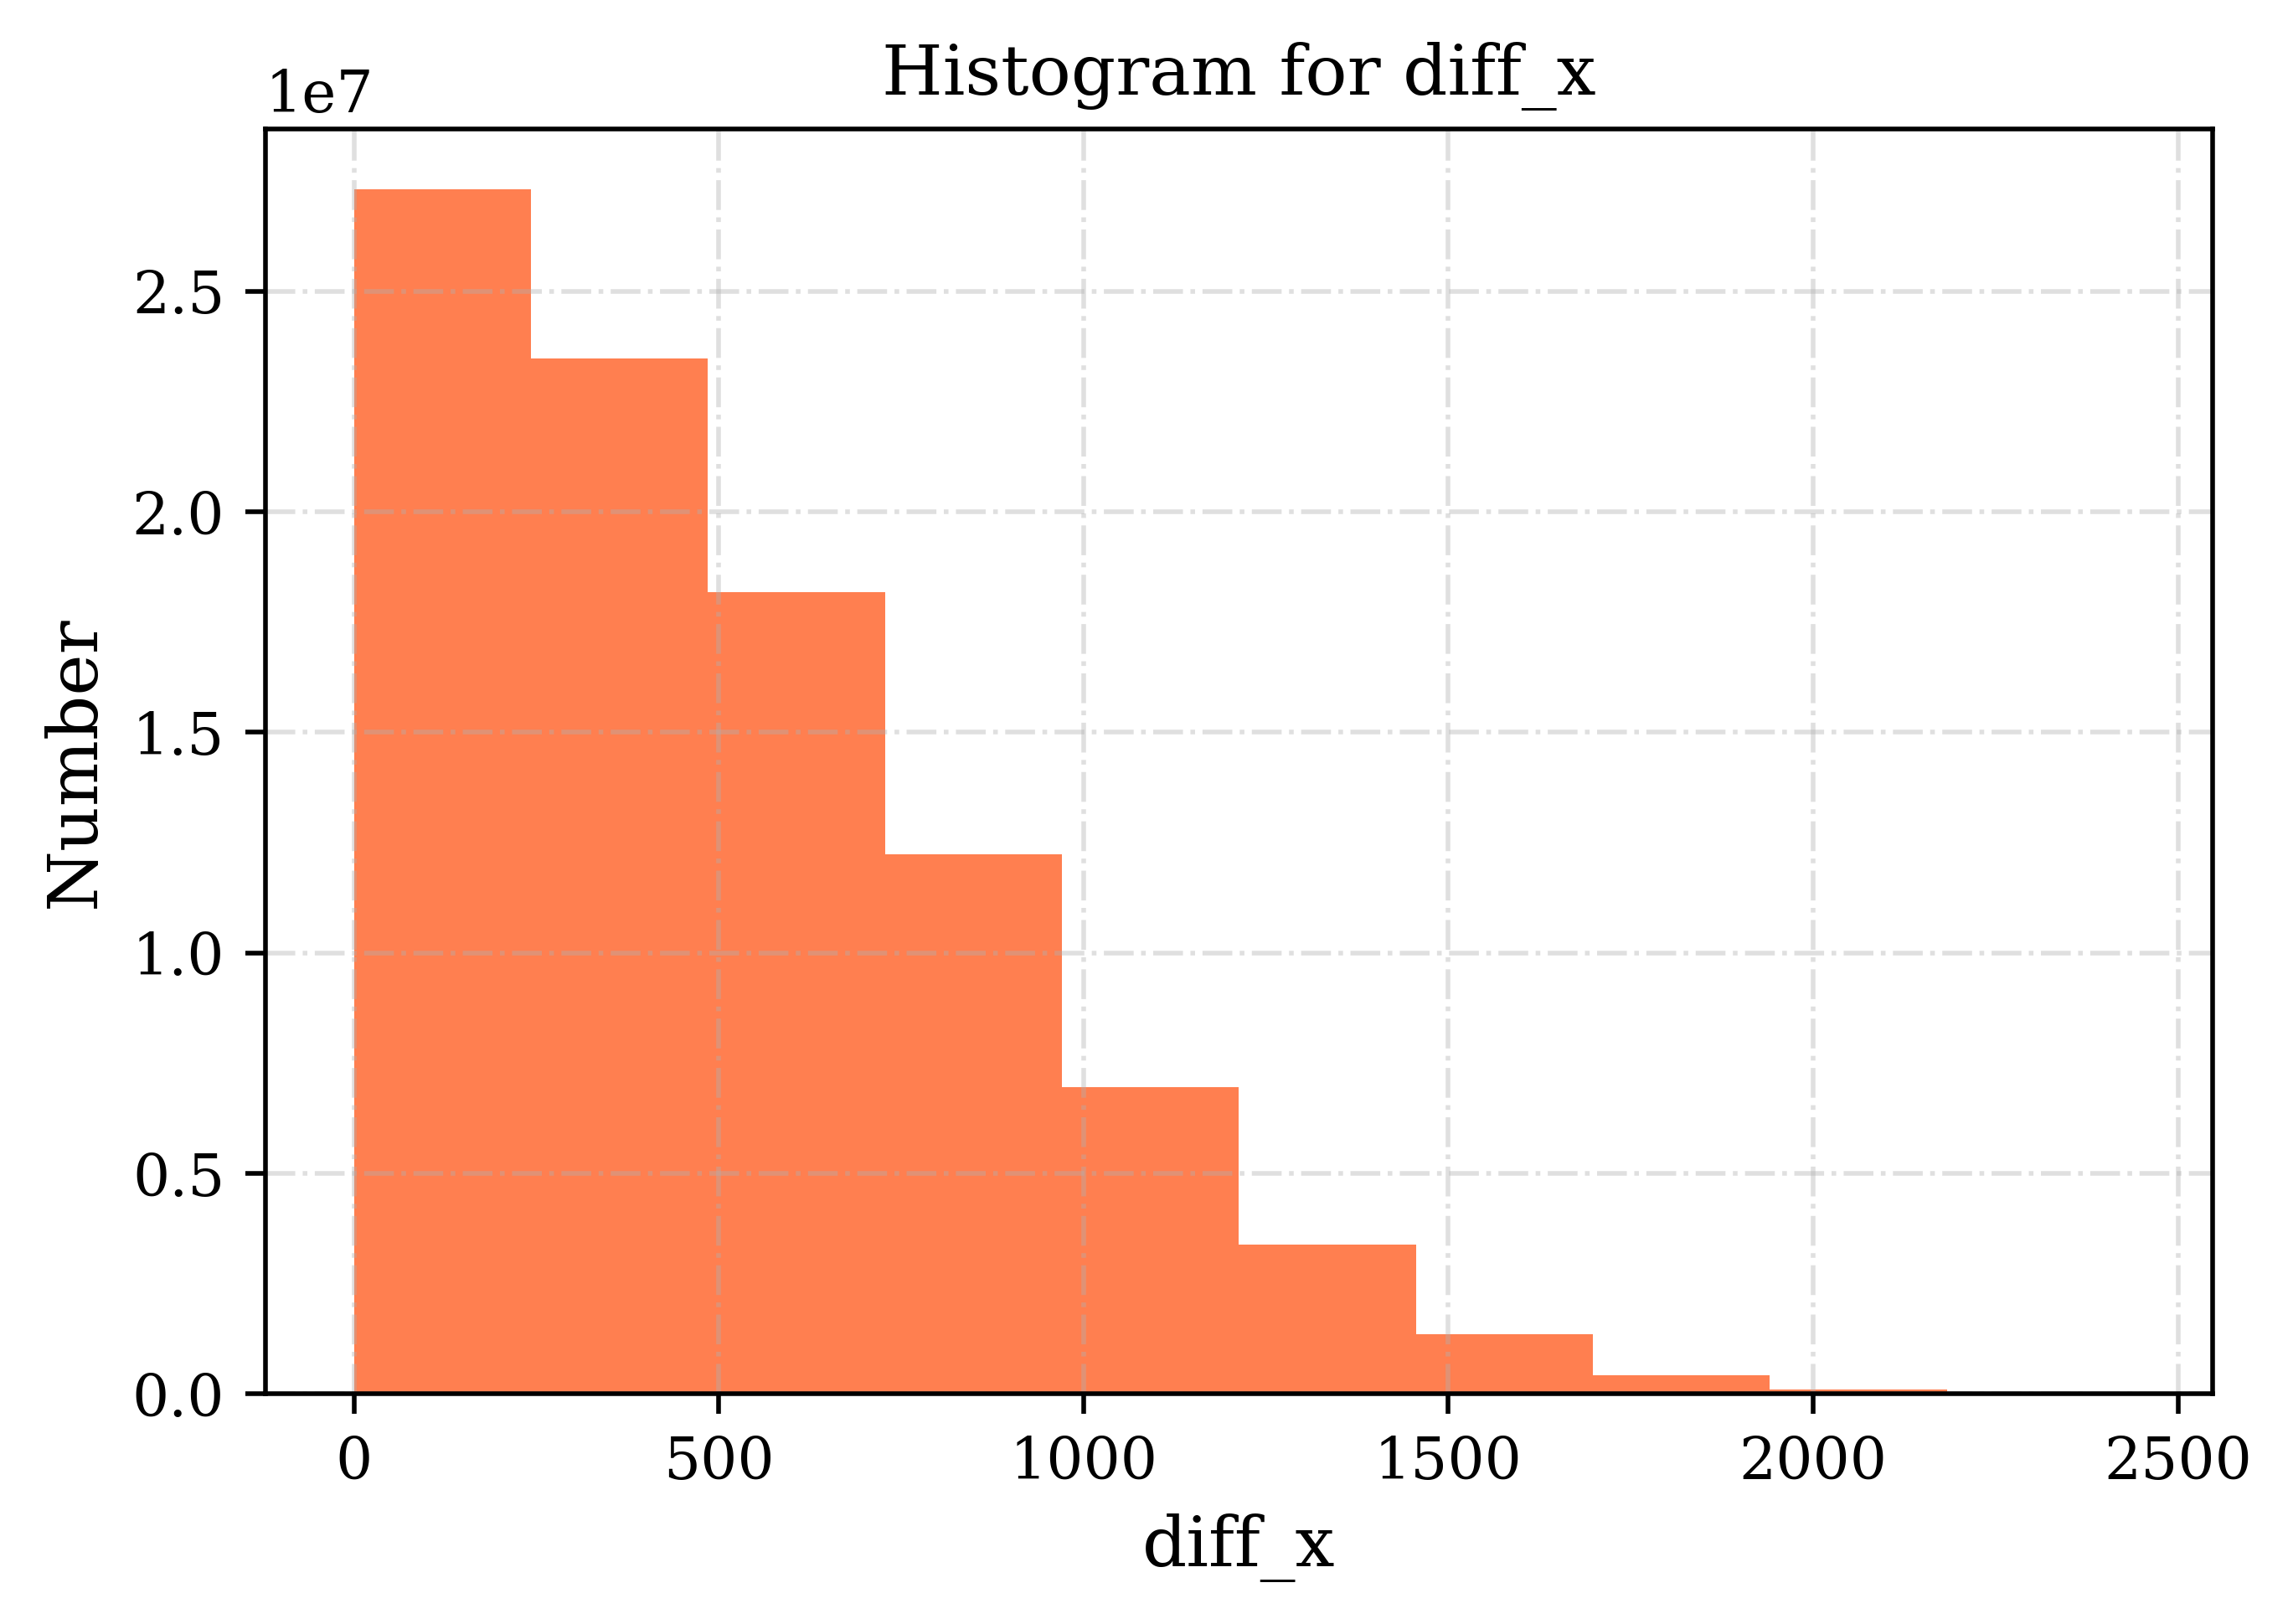

In [26]:
#Histogram of delta values
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for diff_x',fontsize=12)                                         
plt.xlabel(r'diff_x',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   


plt.hist(abs(diff_x) , color='coral')                                                                       


#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                   
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

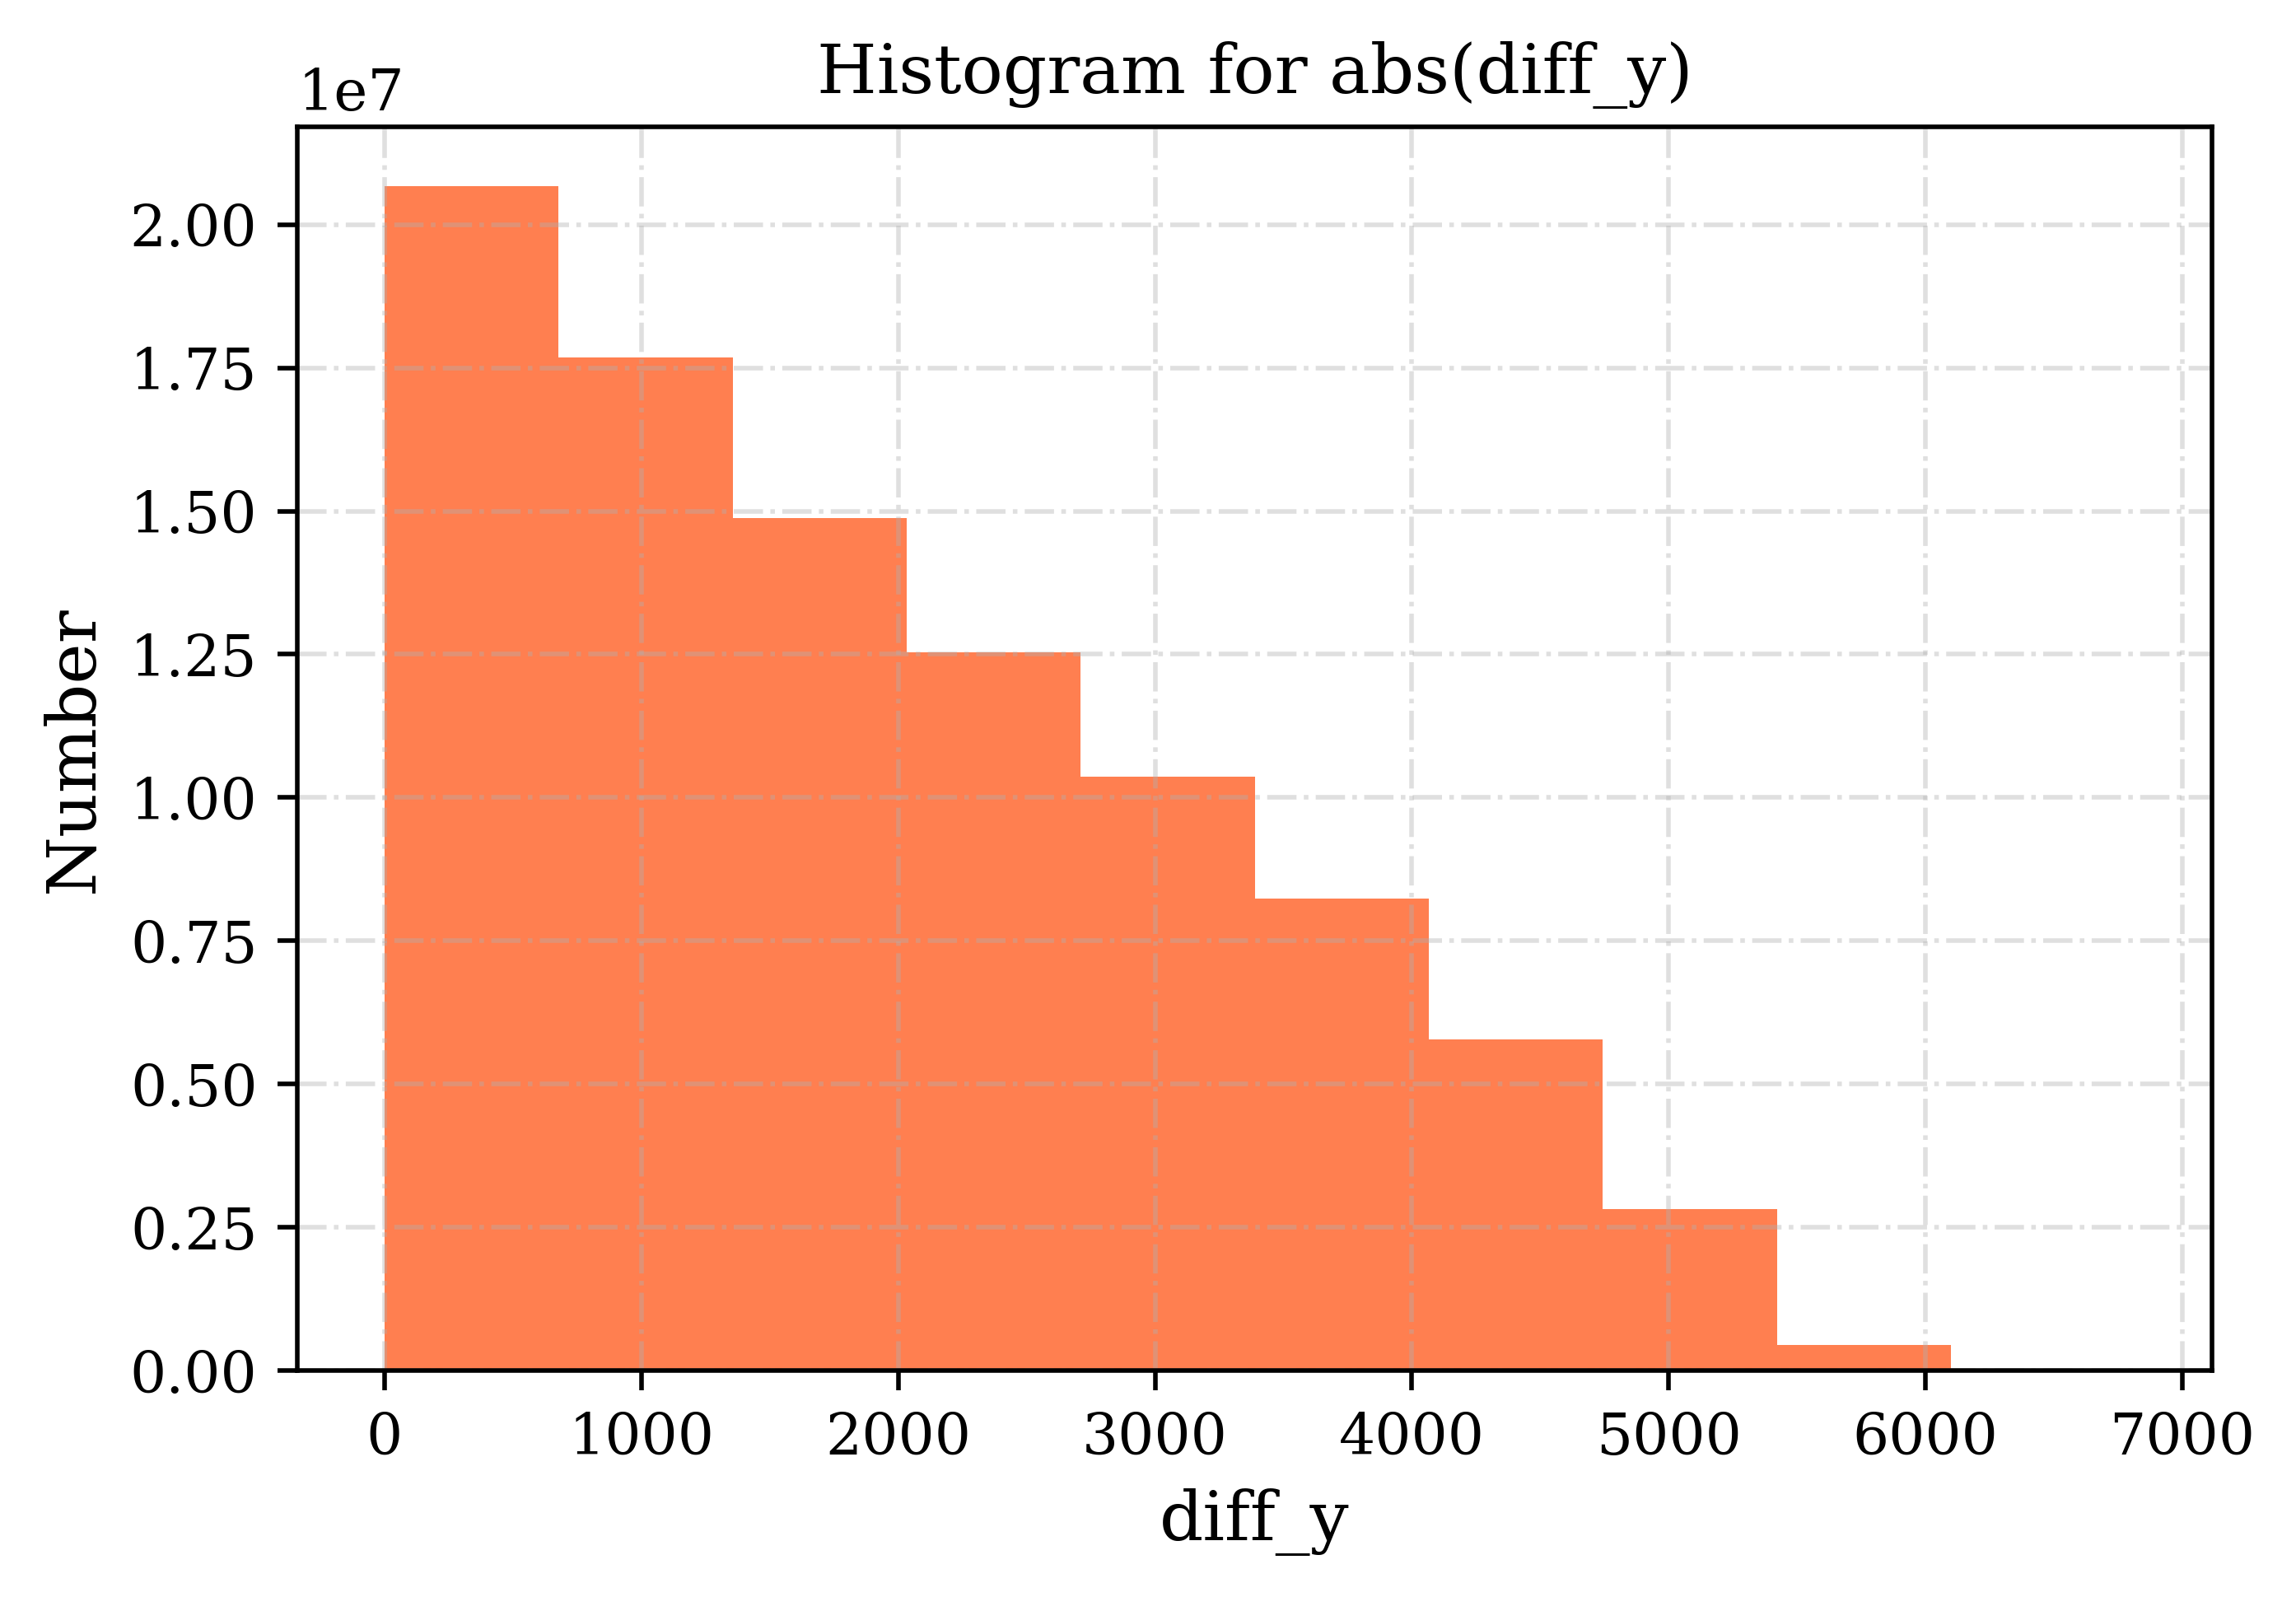

In [27]:
#Histogram of delta values
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for abs(diff_y)',fontsize=12)                                         
plt.xlabel(r'diff_y',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   


plt.hist(abs(diff_y) , color='coral')                                                                       


#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                   
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

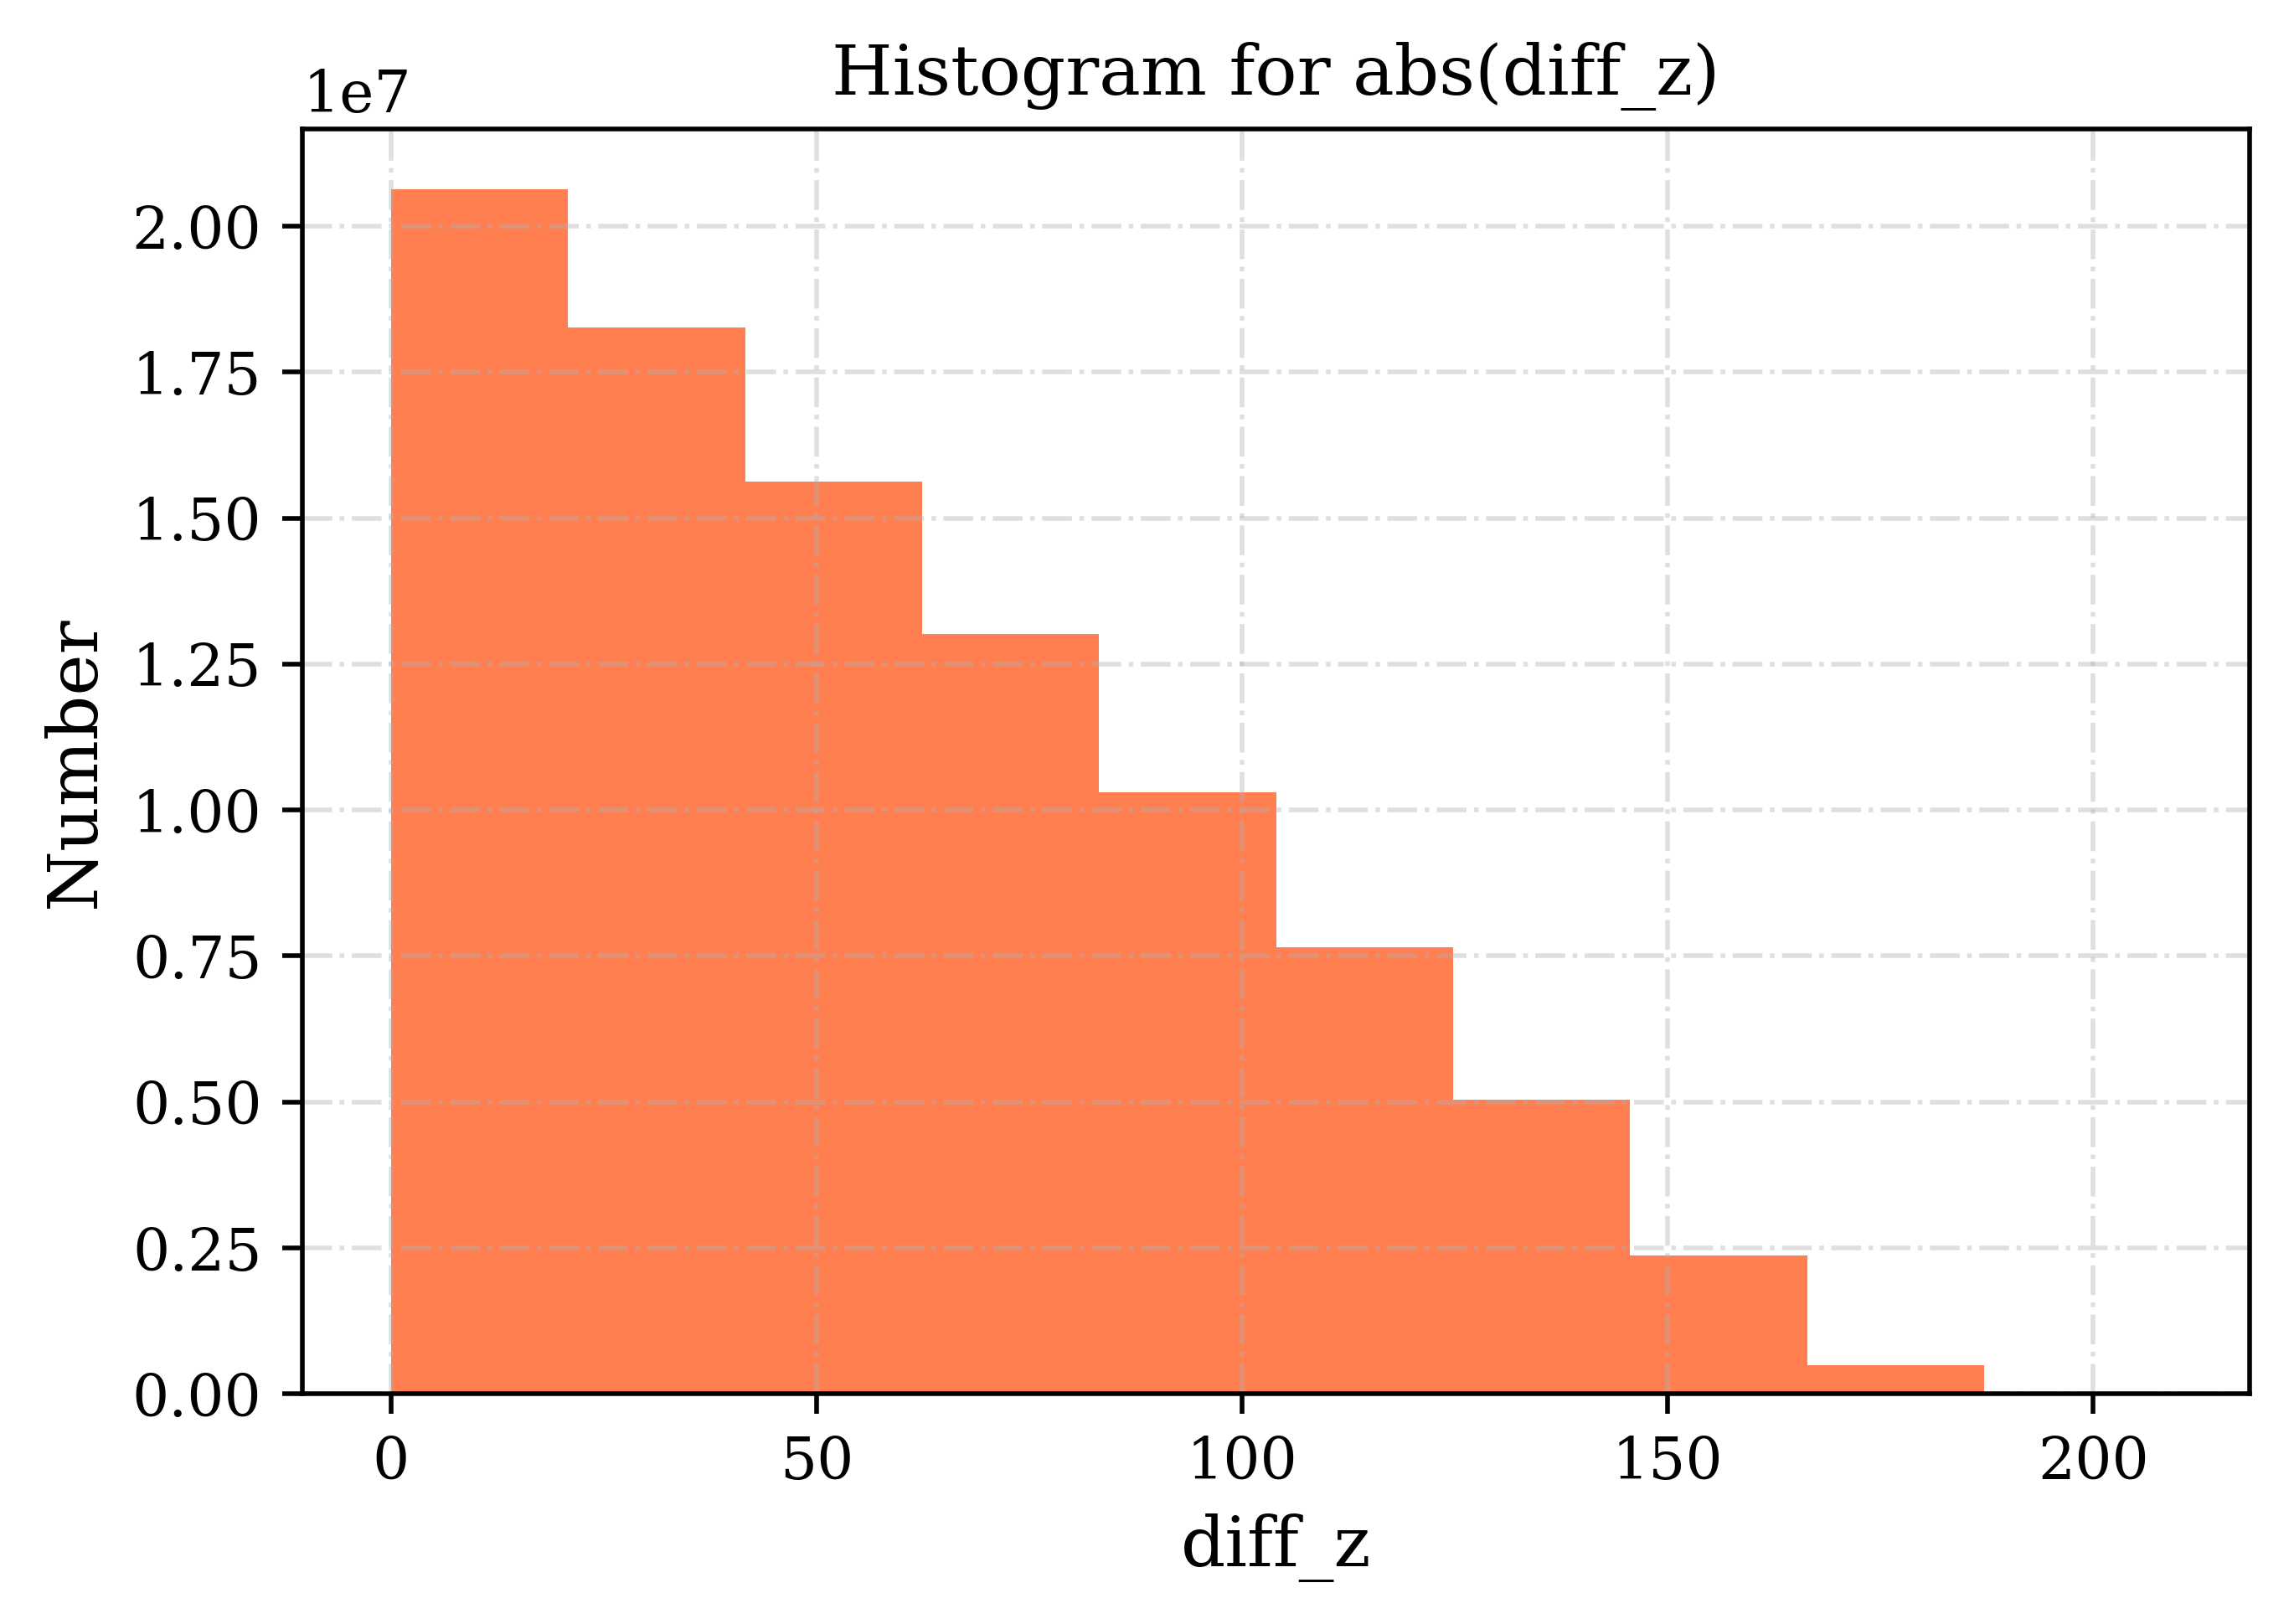

In [28]:
#Histogram of delta values
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for abs(diff_z)',fontsize=12)                                         
plt.xlabel(r'diff_z',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   


plt.hist(abs(diff_z) , color='coral')                                                                       


#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                   
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

In [29]:
np.mean(abs(diff_x))

513.1749171996504

In [30]:
np.median(abs(diff_x))

439.254935196881

In [31]:
np.mean(abs(diff_z))

58.75192124579621

In [32]:
np.median(abs(diff_z))

51.55939873938816

In [33]:
np.median(abs(diff_y))

1721.6851056831697

In [34]:
np.mean(abs(diff_y))

1963.766576993214

## Do that instead for RA,DEC with closest neighbor

In [35]:
diff_ra=np.zeros(len(quasars['ra'])*len(quasars['ra'])+len(quasars['ra']))
diff_ra_min=np.zeros(len(quasars['ra']))

for i in range(len(quasars['ra'])):
    for j in range(len(quasars['ra'])):
        diff_ra[i*len(quasars['ra'])+j]=abs(quasars['ra'][i]-quasars['ra'][j])

In [36]:
len(diff_ra)

93441222

In [37]:
len(quasars)

9666

In [38]:
diff_ra

array([0.        , 0.20929188, 0.29331186, ..., 0.        , 0.        ,
       0.        ])

In [39]:
diff_ra[diff_ra==0]=99999999

In [40]:
len(diff_ra)+len(quasars)

93450888

In [41]:
i=len(quasars)-1
diff_ra[(i*len(quasars['ra'])):(i*len(quasars['ra'])+len(quasars['ra']))]

array([2.36145063e+01, 2.34052145e+01, 2.33211945e+01, ...,
       2.38441782e-01, 1.19768535e-01, 9.99999990e+07])

In [42]:
for i in range(len(quasars['ra'])):
    diff_ra_min[i]= np.min(diff_ra[(i*len(quasars['ra'])):(i*len(quasars['ra'])+len(quasars['ra']))])

In [43]:
len(diff_ra_min)

9666

In [44]:
len(diff_ra_min[diff_ra_min==0])

0

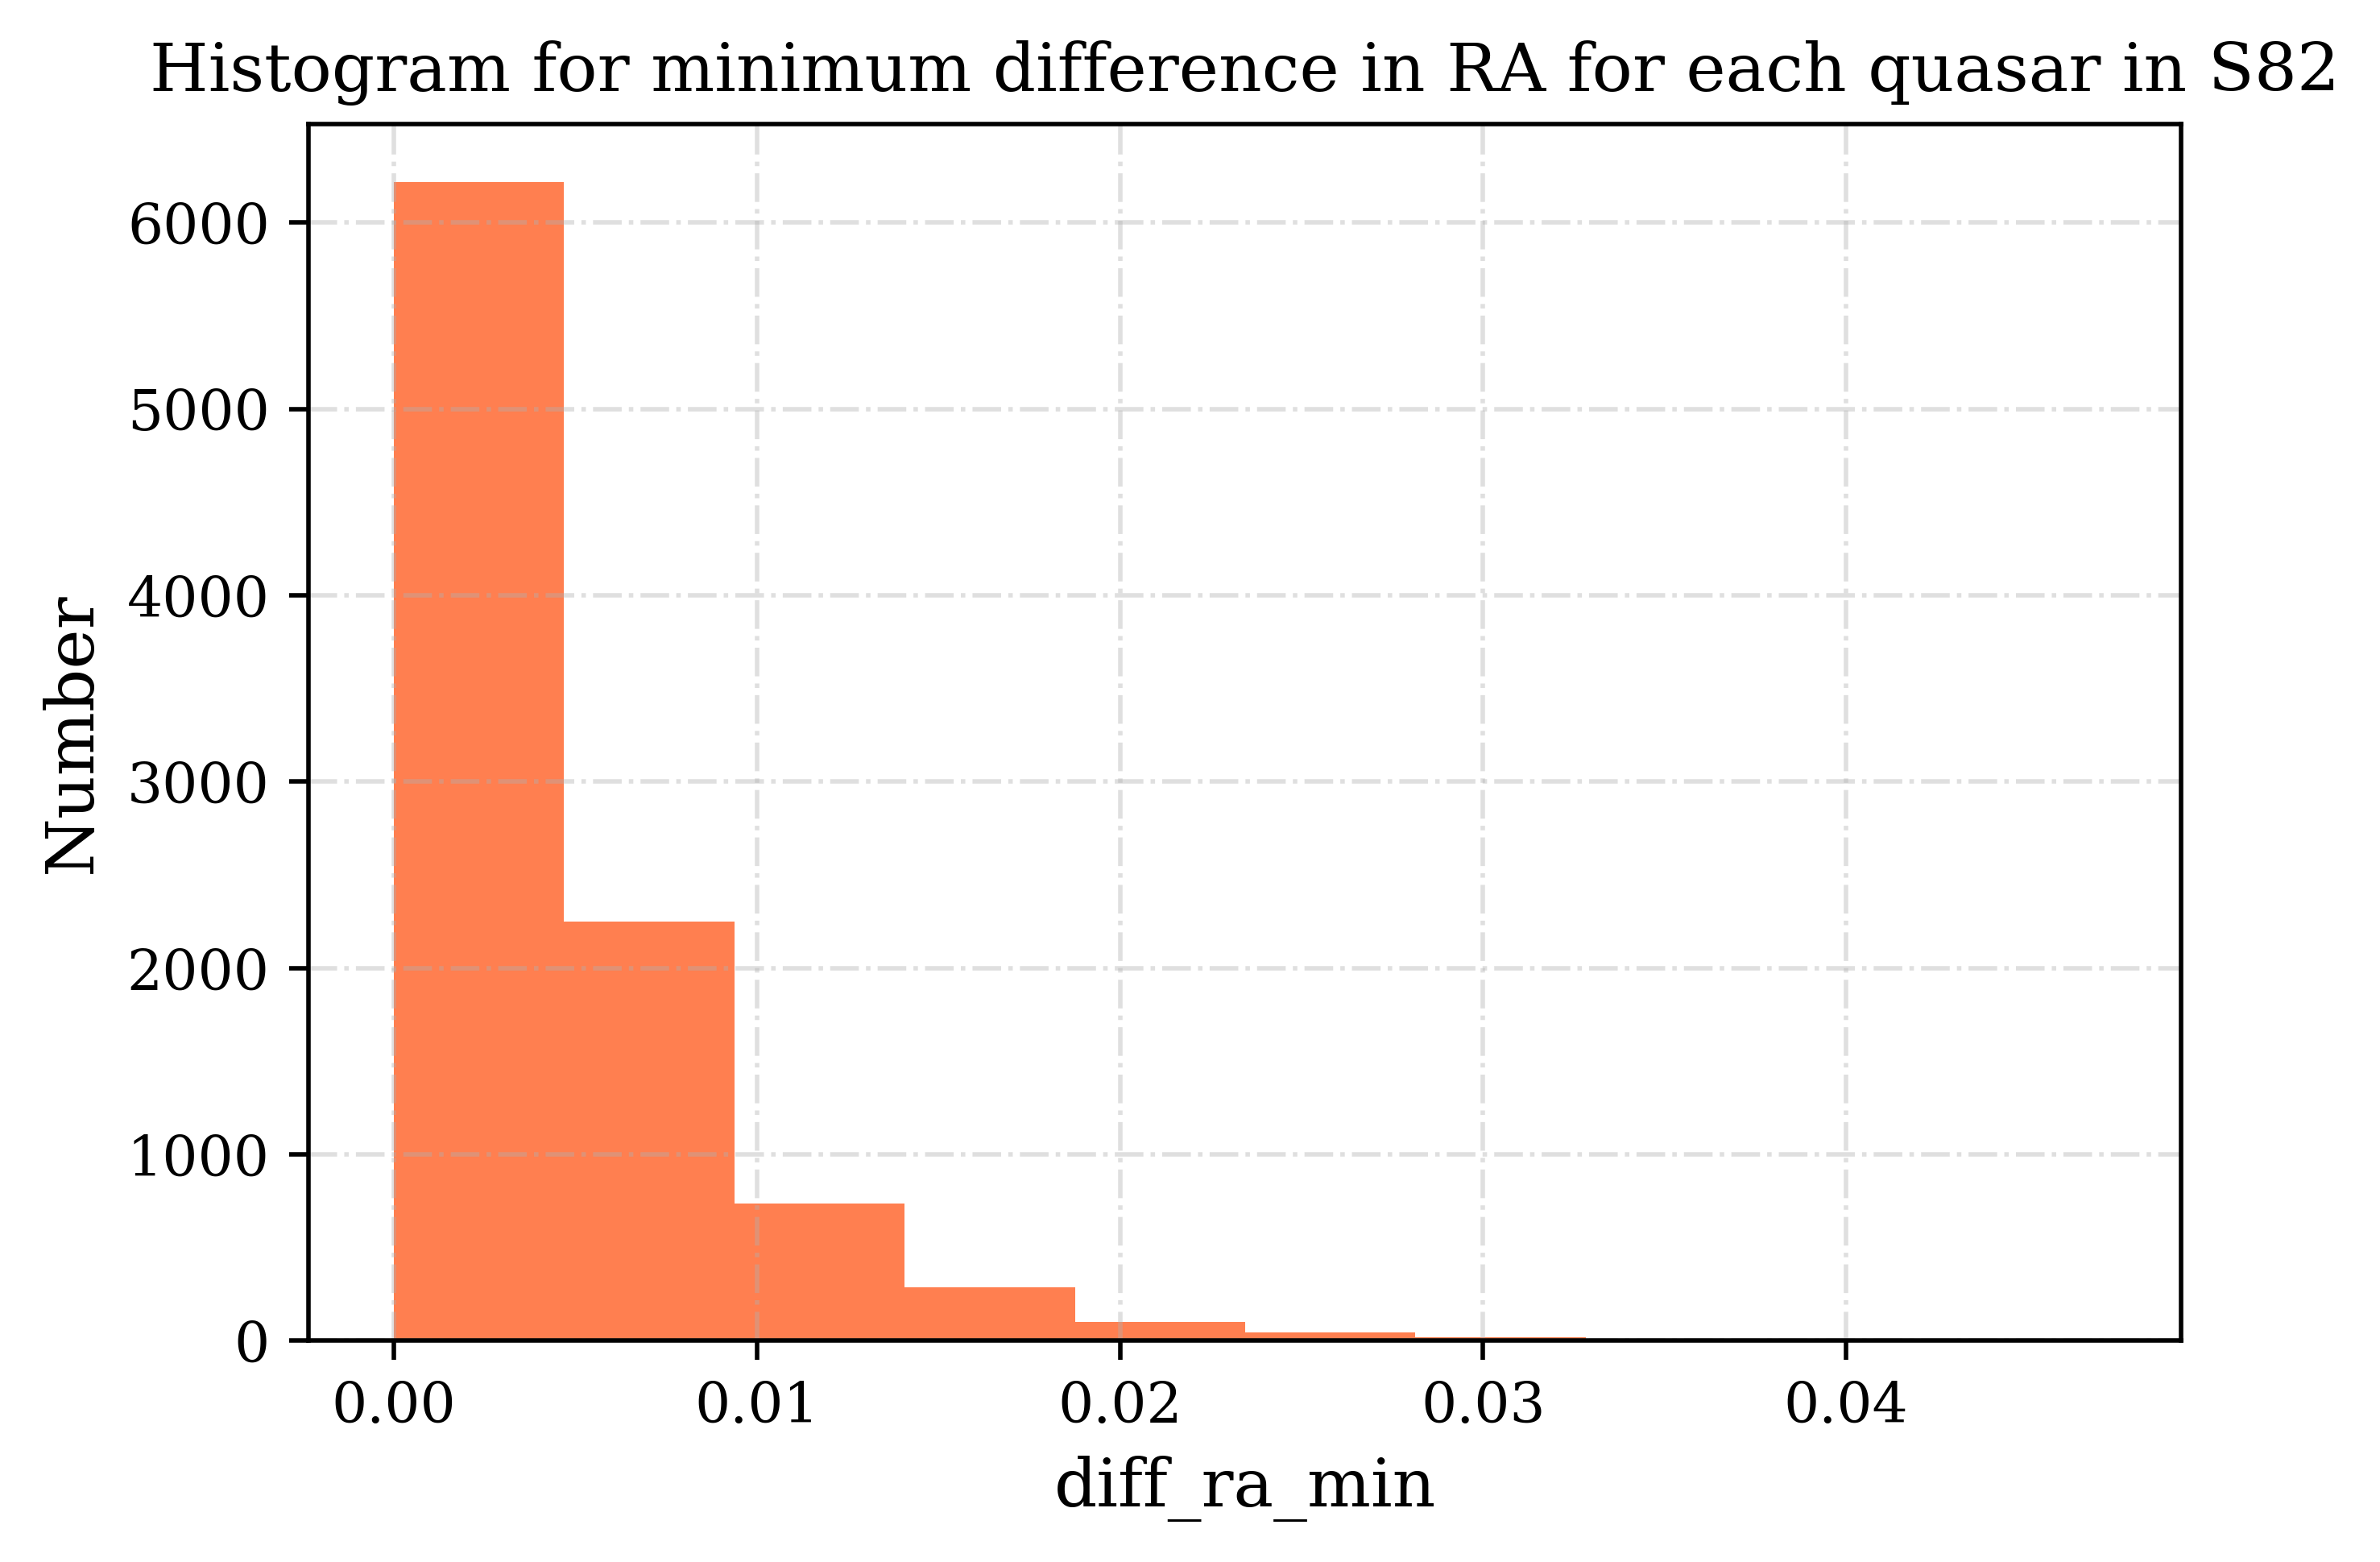

In [45]:
#Histogram of delta values
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for minimum difference in RA for each quasar in S82',fontsize=12)                                         
plt.xlabel(r'diff_ra_min',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   


plt.hist(diff_ra_min , color='coral')                                                                       


#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                   
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

In [46]:
min(diff_ra_min)

2.1954694773285155e-06

In [47]:
max(diff_ra_min)

0.04688691050083715

In [48]:
diff_dec=np.zeros(len(quasars['dec'])*len(quasars['dec'])+len(quasars['dec']))
diff_dec_min=np.zeros(len(quasars['dec']))

for i in range(len(quasars['dec'])):
    for j in range(len(quasars['dec'])):
        diff_dec[i*len(quasars['dec'])+j]=abs(quasars['dec'][i]-quasars['dec'][j])

In [49]:
len(diff_dec)

93441222

In [50]:
len(quasars)

9666

In [51]:
diff_dec[diff_dec==0]=99999999

In [52]:
for i in range(len(quasars['dec'])):
    diff_dec_min[i]= np.min(diff_dec[(i*len(quasars['dec'])):(i*len(quasars['dec'])+len(quasars['dec']))])

In [53]:
len(diff_dec_min[diff_dec_min==0])

0

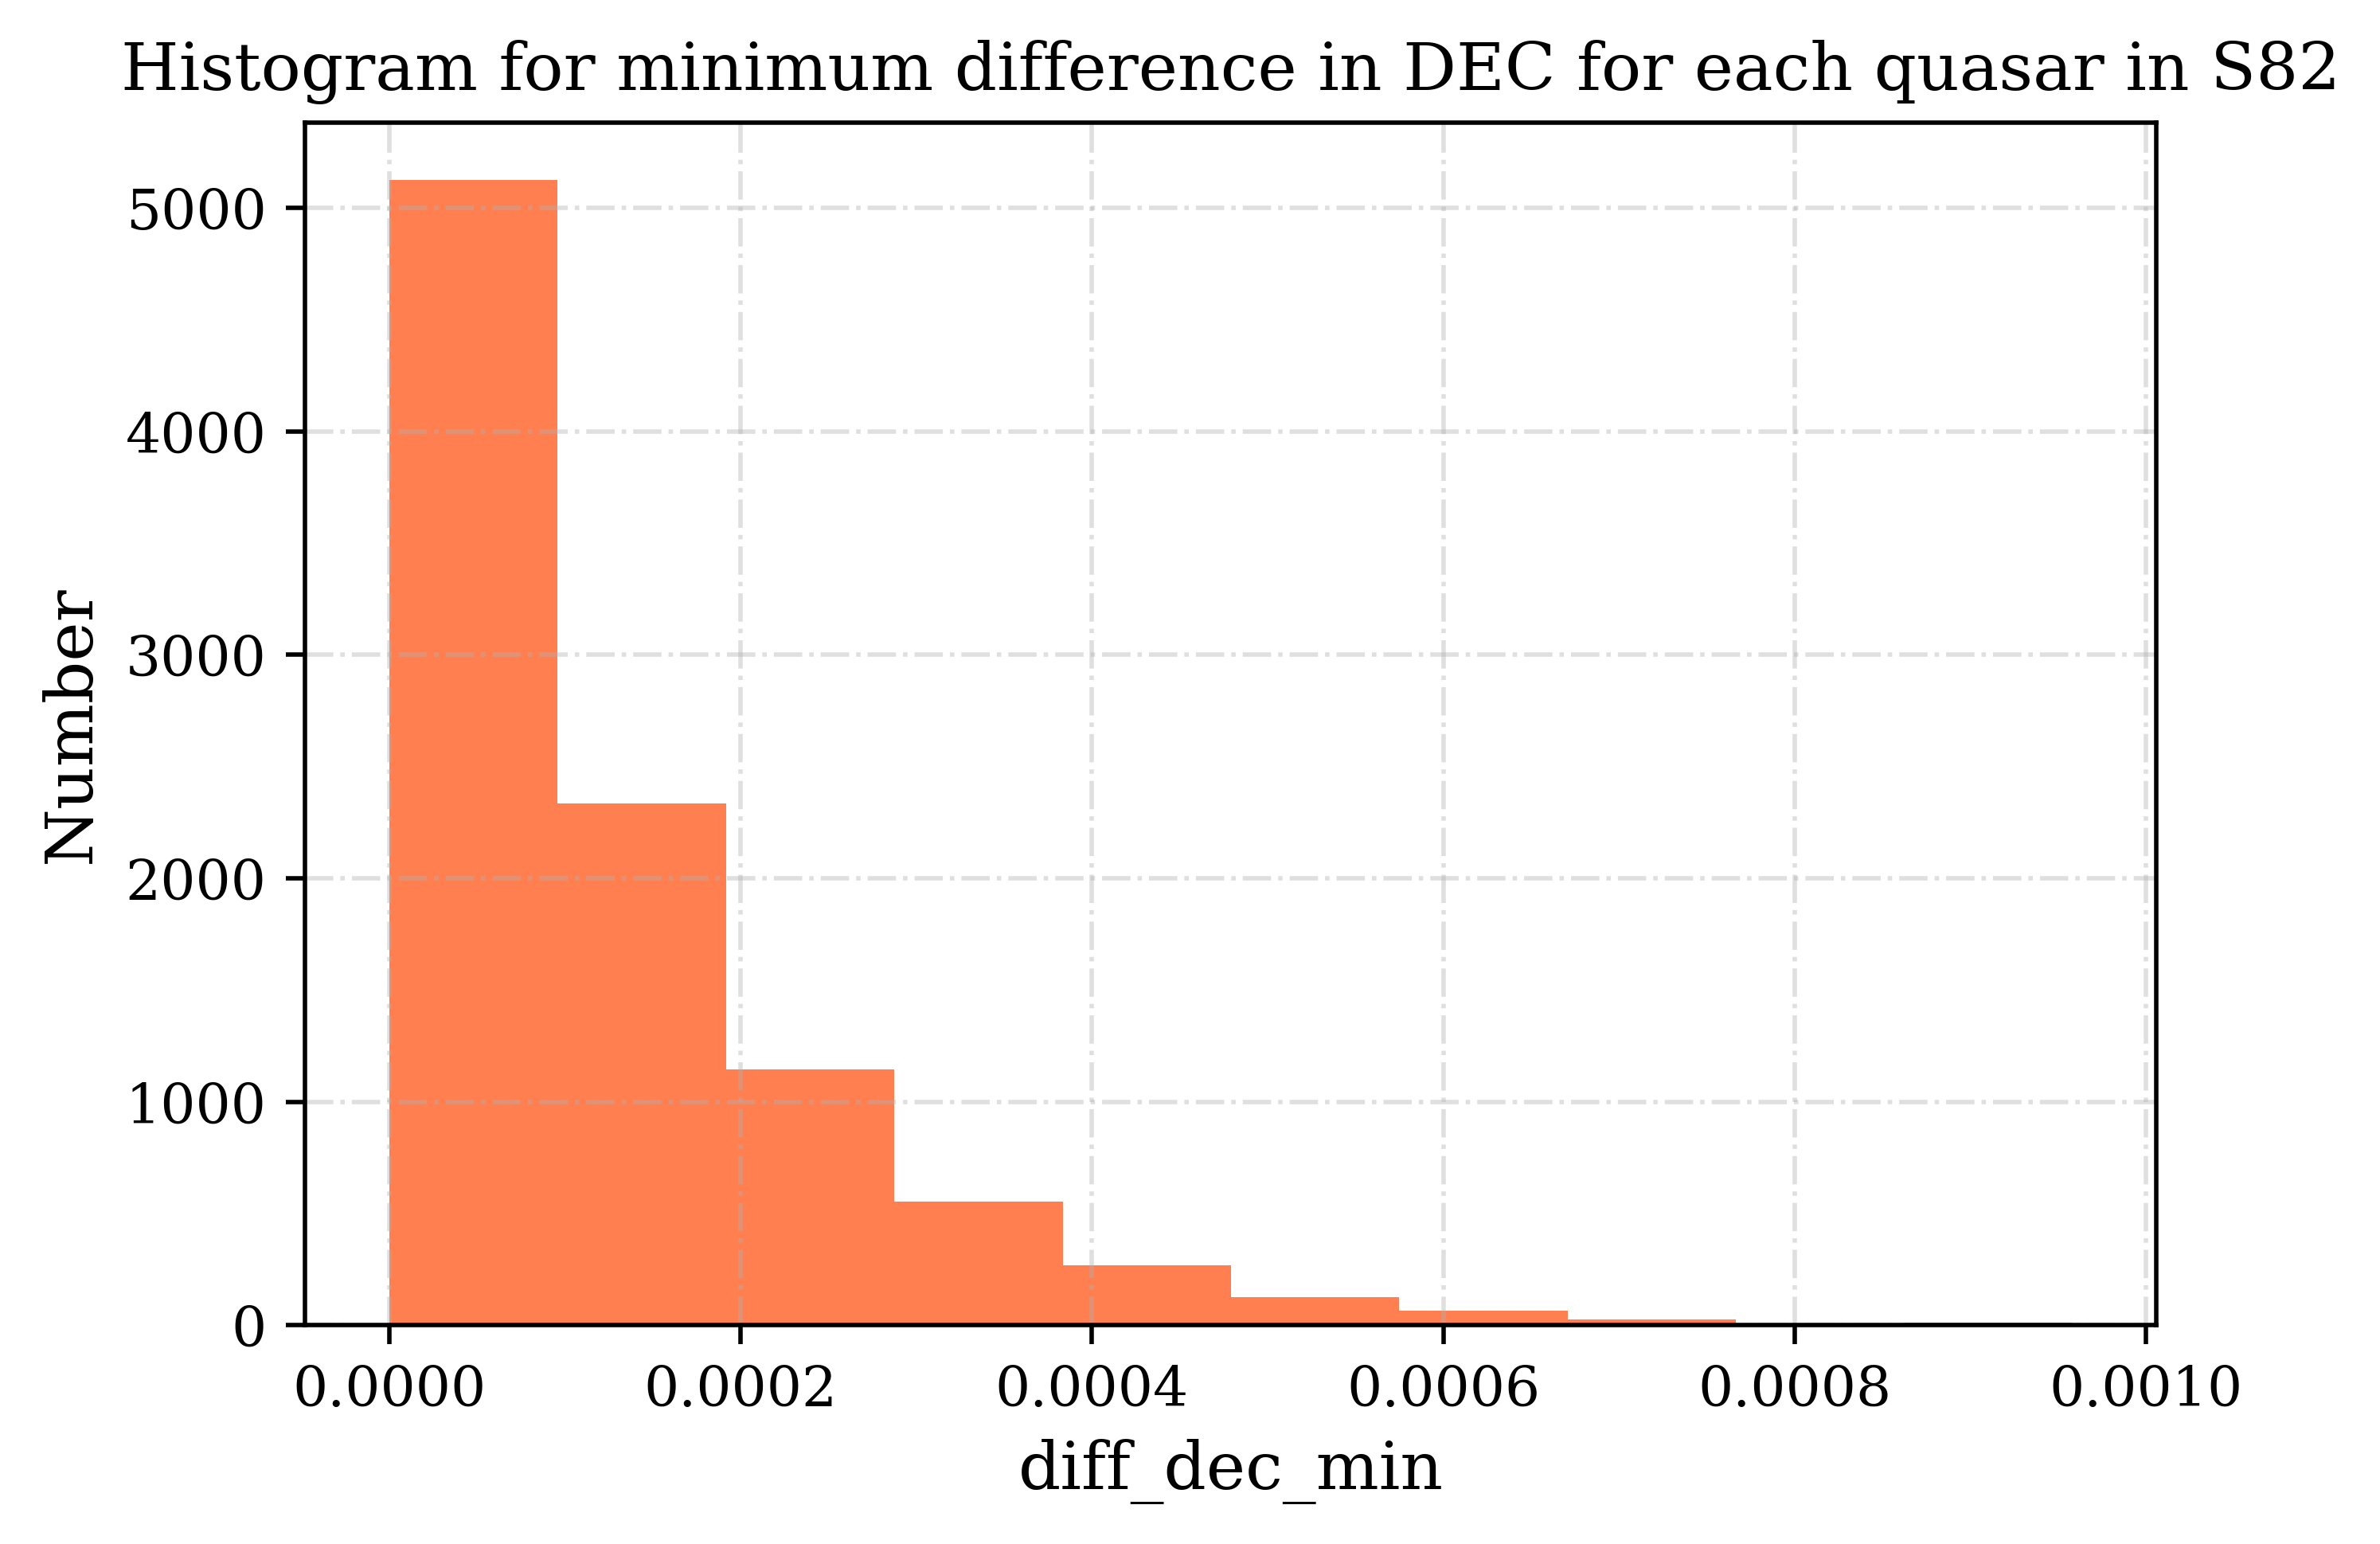

In [54]:
#Histogram of delta values
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for minimum difference in DEC for each quasar in S82',fontsize=12)                                         
plt.xlabel(r'diff_dec_min',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   


plt.hist(diff_dec_min , color='coral')                                                                       


#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                   
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

In [55]:
min(diff_dec_min)

1.7861145673592205e-08

In [56]:
max(diff_dec_min)

0.0009582387276967363

(6360, 180, 834) pixels for ~(90,2.5,1.1)

In [57]:
6360/90

70.66666666666667

In [58]:
180/2.5

72.0

In [59]:
min(diff_ra_min)*6360/90

0.0001551465097312151

In [60]:
max(diff_ra_min)*6360/90

3.3133416753924925

In [61]:
min(diff_dec_min)*180/2.5

1.2860024884986387e-06

In [62]:
max(diff_dec_min)*180/2.5

0.06899318839416502